In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

2024-04-21 09:26:12.518031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 09:26:12.518149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 09:26:12.636387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#loading dataframes
train_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-training-dataset.csv')
test_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-test-dataset.csv')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


In [3]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
         id  boneage   male  bone_age_z
0  1377.png      180  False    1.279181
1  1378.png       12  False   -2.800269
2  1379.png       94  False   -0.809109
3  1380.png      120   True   -0.177766
4  1381.png       82  False   -1.100498


Text(0.5, 1.0, 'Number of children in each age group')

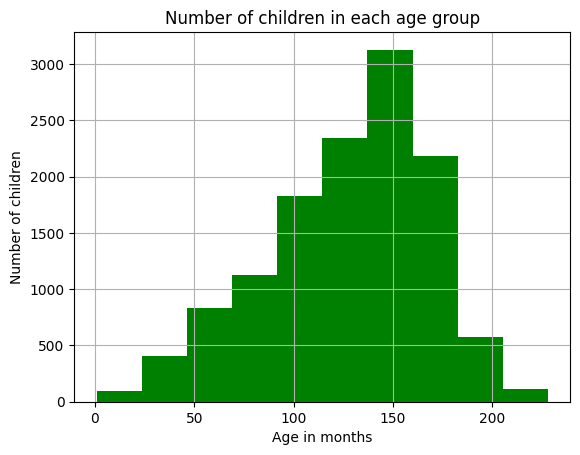

In [4]:
#plotting a histogram for bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

In [5]:
#splitting train dataframe into traininng and validation dataframes
train_df['boneage_category'] = pd.cut(train_df['boneage'], 10)
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)

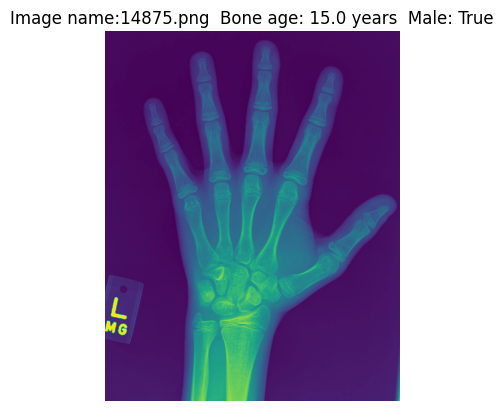

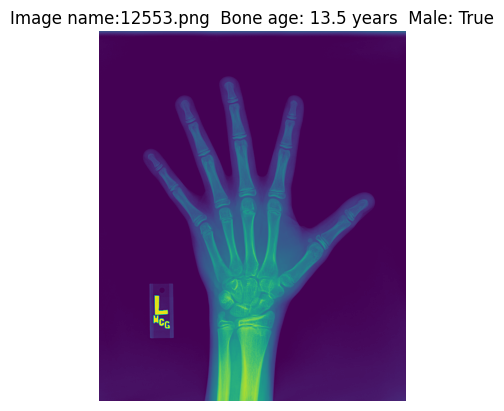

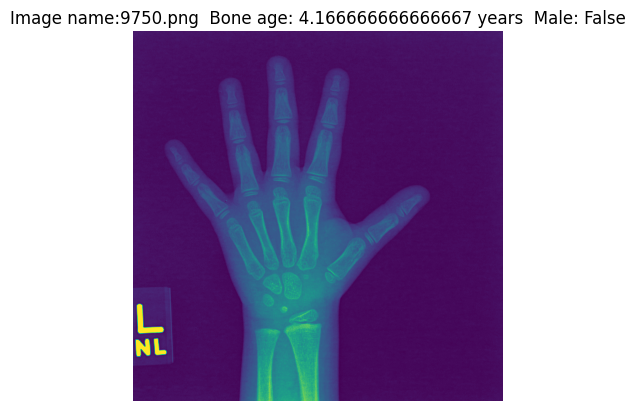

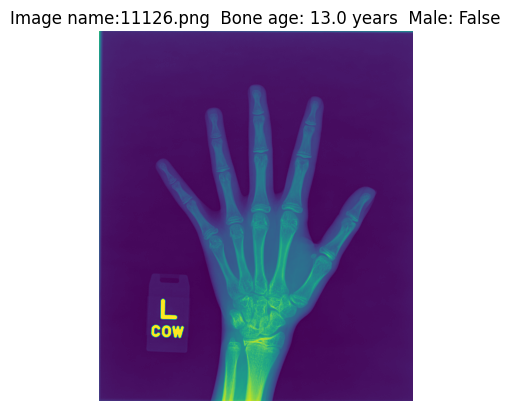

In [6]:
import matplotlib.image as mpimg
for filename, boneage, gender in train_df[['id','boneage','male']].sample(4).values:
    img = mpimg.imread('/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/'+ filename)
    plt.imshow(img)
    plt.title('Image name:{}  Bone age: {} years  Male: {}'.format(filename, boneage/12, gender))
    plt.axis('off')
    plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

#reducing down the size of the image 
img_size = 299
data_augmenation = dict(rotation_range=0.2, zoom_range=0.1, horizontal_flip=True,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                shear_range=0.05, fill_mode='nearest')
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input,  **data_augmenation)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
    x_col = 'id',
    y_col = 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory = '/kaggle/input/rsna-bone-age/boneage-test-dataset',
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

Found 10088 validated image filenames.
Found 2523 validated image filenames.
Found 200 images belonging to 1 classes.


In [8]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            df_valid, 
                            directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
                            x_col = 'id',
                            y_col = 'bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 2523,
                            class_mode = 'other'
                            )) 

Found 2523 validated image filenames.


In [9]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [10]:
from keras.metrics import mean_absolute_error

def mae_in_months(x_p, y_p):
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age))

In [11]:
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

model_1 = tf.keras.applications.DenseNet201(input_shape = (img_size, img_size, 3),
                                           include_top = False,
                                           weights = 'imagenet')
model_1.trainable = True
model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(64, activation = 'relu'))
# model_2.add(Dropout(0.5))
model_2.add(Dense(32, activation = 'relu'))
model_2.add(Dense(1, activation = 'linear'))

Sgd = tf.keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.0, nesterov=False)
NaDam = tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
AdaMax = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
#compile model
model_2.compile(loss ='mse', optimizer= AdaMax, metrics = [mae_in_months] )
model_2.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ ?                      │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [12]:
%load_ext tensorboard
logs_dir = '.\logs'
%tensorboard --logdir {logs_dir}

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-21 09:36:25.932653: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_123102__.85057] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-04-21 09:36:31.688742: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m5.756197355s

********************************
[Compiling module a_inference_one_step_on_data_123102__.85057] Very slow compile? If you want to file a bug, run with envvar XLA_FLA

 89/315 ━━━━━━━━━━━━━━━━━━━━ 8:31 2s/step - loss: 7.5316 - mae_in_months: 59.8715

2024-04-21 09:45:15.645183: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m33.816521053s

********************************
[Compiling module a_inference_one_step_on_data_123102__.85057] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
W0000 00:00:1713692715.911976      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.1040 - mae_in_months: 36.2944

W0000 00:00:1713693250.500209      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 1496s 3s/step - loss: 3.0970 - mae_in_months: 36.2516 - val_loss: 0.2511 - val_mae_in_months: 17.9427 - learning_rate: 0.0010
Epoch 2/60
  1/315 ━━━━━━━━━━━━━━━━━━━━ 4:27 853ms/step - loss: 0.2468 - mae_in_months: 16.5813

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2468 - mae_in_months: 16.5813 - val_loss: 0.4337 - val_mae_in_months: 22.2928 - learning_rate: 0.0010
Epoch 3/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 598s 2s/step - loss: 0.2210 - mae_in_months: 15.2377 - val_loss: 0.1345 - val_mae_in_months: 12.6301 - learning_rate: 0.0010
Epoch 4/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 0.1910 - mae_in_months: 13.5551 - val_loss: 0.1387 - val_mae_in_months: 13.1595 - learning_rate: 0.0010
Epoch 5/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 591s 2s/step - loss: 0.1649 - mae_in_months: 13.2764 - val_loss: 0.2241 - val_mae_in_months: 14.8838 - learning_rate: 0.0010
Epoch 6/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2190 - mae_in_months: 15.7312 - val_loss: 0.1293 - val_mae_in_months: 12.7780 - learning_rate: 0.0010
Epoch 7/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - loss: 0.1445 - mae_in_months: 12.4144 - val_loss: 0.1474 - val_mae_in_months: 12.4080 - learning_rate: 0.0010
Epoch 8/60
315/315 ━━

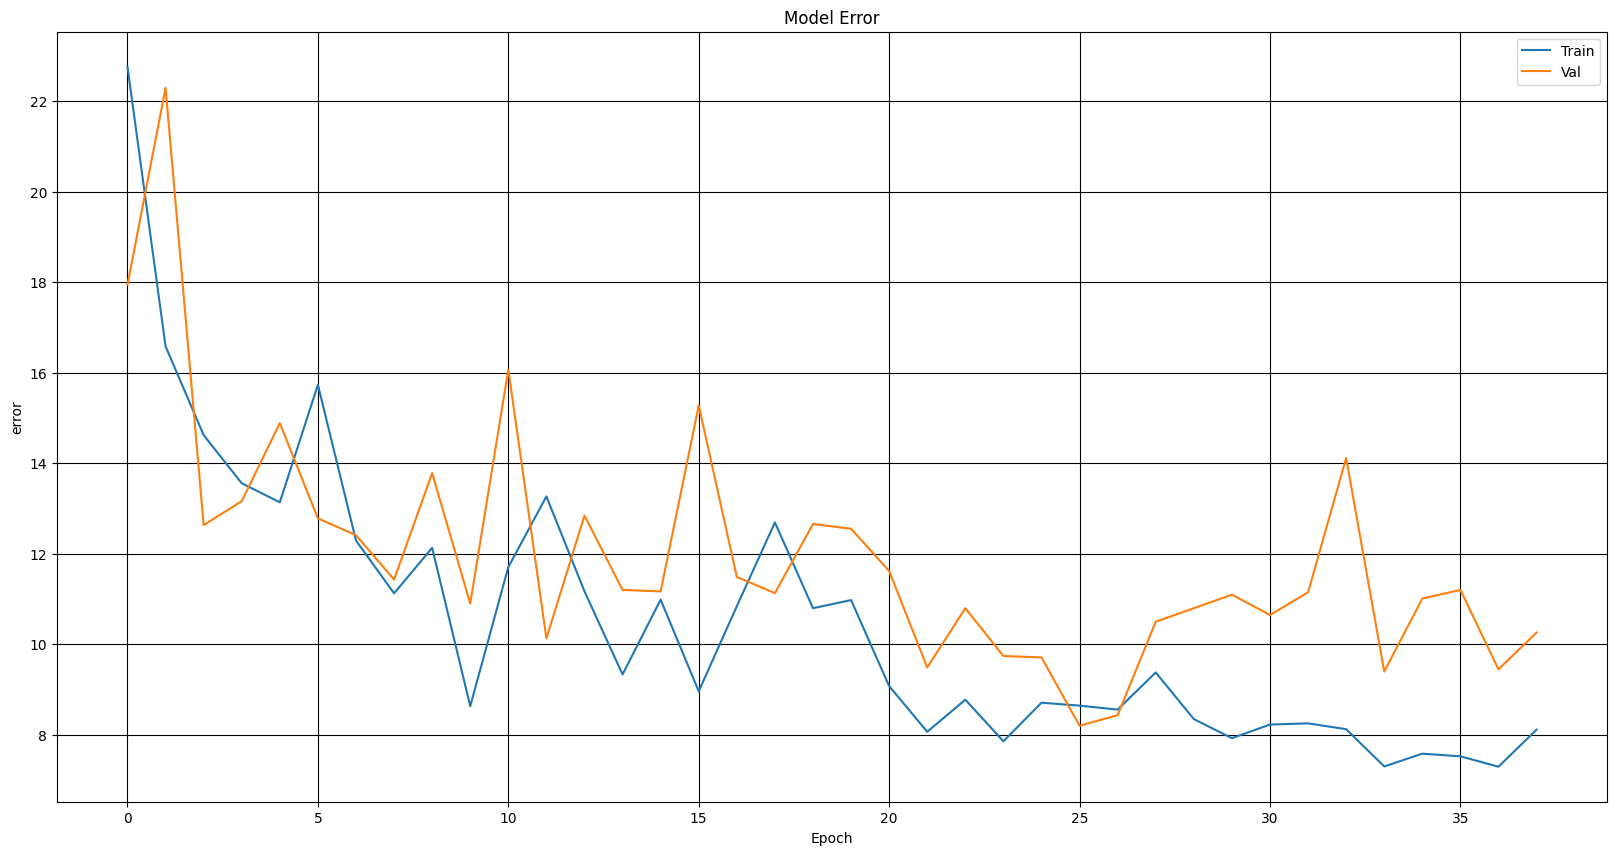

In [13]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 12,
                              verbose=0, mode='auto')

#model checkpoint
mc = ModelCheckpoint('resnet50_best_imsize299_model.keras', monitor='val_loss', mode='min', save_best_only=True,save_weights_only = False)
# mc = ModelCheckpoint('xception_best_imsize299_model2.h5', monitor='val_loss', mode='min', save_best_only=True,save_weights_only = False)

#tensorboard callback
logdir = os.path.join(logs_dir,datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback =  TensorBoard(logdir, histogram_freq = 1)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]
callbacks = [early_stopping,mc, red_lr_plat]


#fit model
history = model_2.fit(train_generator,
                            steps_per_epoch = 315,
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = 60,
                            callbacks= callbacks)
history
%tensorboard --logdir logs
plot_it(history)